#                                   Description Triangle Algorithm                                   #
                                        
####################### each crownstone #######################                           

1a: Scan for surrounding nodes, store the UUID and the RSSI, filter on RSSI if needed \
1b: Communicate with all the surrounding nodes, request RSSI and update the edges in the formed array/table \
#------------------->: Edge(node_src/node_dst/RSSI) \
2: If 2 edges are formed, Try making a trinagle, by asking both edge_Dst if they can see each other \
2a Example: start at the top of the list, take a = list(i) and b = list(i+1) / two best connections, like: c1/c2/-45 and c1/c3/-47 \
2b send message to both Crownstones, in this example c2 and c3, to ask if they can see each other in there surounding nodes list \
2c If there is a node/vertice match, make a triangle with pointers to the edges \
#-------------------> Triangle(edgeP1/edgeP2/edgeP3) \

####################### Communication ####################### 
                                        
Between two Crownstones: \
1: Request: check his connections on a specific Crownstone \
<->  \
2: Answer: specific Crownstone connection values in format: cX(already known)/cY/RSSI \

Mesh message between all Crownstones:\ 
1: Global request for exchange of triangles to Hub \
2: Every Cronwstone sends its best triangles (max 3-5) \

####################### Processing/Mapping ####################### 

All triangles will be send to the hub. The hub will further process the triangles to a map.


In [59]:
# Run once to install all packages needed
# %pip install ipympl, matplotlib, networkx, pandas, numpy 

In [60]:
%matplotlib widget

import random
from random import normalvariate
import math
from math import sqrt, log10
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import networkx as nx
from IPython.display import display, clear_output
import ipywidgets as widgets
from collections import Counter
import threading
import time

In [61]:
#-----------------------------------------#

random.seed(7)
num_nodes = 5

#-----------------------------------------#

In [62]:
# Plot the reference node network
def compareGraph3D(Network_Dict, RefNode_List):
    G = nx.Graph()

    i = 0
    for nodeID, edges in Network_Dict.items():
        G.add_node(nodeID, pos=RefNode_List[i])
        for edge in edges:
            G.add_edge(edge.src.uuid, edge.dst.uuid, Rssi=edge.rssi)
        i += 1

    pos = nx.get_node_attributes(G, 'pos')
    rssi = nx.get_edge_attributes(G, "Rssi")

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis

    # Draw nodes as scatter plot and text labels
    for nodeID, coords in pos.items():
        ax.scatter(*coords, c="blue", s=100, marker='o')
        ax.text(*coords, f'Node {nodeID}\n({coords[0]}, {coords[1]}, {coords[2]})', ha='center', va='bottom')

    # Draw edges in 3D
    for edge in G.edges():
        xs, ys, zs = zip(*[pos[edge[i]] for i in range(2)])
        ax.plot(xs, ys, zs, color='black')
        rssi_value = rssi.get(edge, "")
        ax.text(sum(xs)/2,sum(ys)/2,sum(zs)/2, f"{rssi_value:.3f}", color='red')

    ax.set_title("Node plot with signal strength (RSSI) (3D)")
    plt.show()

# Convert the length between two coordinates to RSSI
def distance_to_rssi(nodeCoord1, nodeCoord2):
    c1x, c1y, c1z = nodeCoord1
    c2x, c2y, c2z = nodeCoord2
    distance = math.sqrt((c1x-c2x)**2 + (c1y-c2y)**2 + (c1z-c2z)**2)
    # noise = normalvariate(0, sqrt(20))
    noise = 0
    rssi = -70 - 10 * 2.0 * log10(distance) + noise
    # return distance
    return rssi


# Convert RSSI into distance, for now a log function or later try neural net conversion
def rssi_to_distance(rssi):
    return (10**((-rssi-70)/(20)))

In [63]:
# Node class, which represents a individual Crownstone
class Node:

    def __init__(self, HWuuid: str):
        self.uuid = HWuuid
        self.coord = (0,0,0)
        self.SurNodes = [] # list of (node reference, rssi)
        self.adjEdgeList = []
        self.oppEdgeList = []
        self.triangleList = []
        self.adjTrianglesDict = {}
   
    def __repr__(self):
        return str(self)
    
    def __str__(self) -> str:
        edges_str = ', '.join(map(str, self.adjEdgeList))
        triangles_str = '\n'.join(map(str, self.triangleList))
        nodes_str = ', '.join(map(str, [node.uuid for node, rssi in self.SurNodes])) 
        oppos_str = ', '.join(map(str, self.oppEdgeList)) 
        line = "------------------------------------------------------------------------------------------------\n"
        return f"{line}Node uuid={self.uuid}:{self.coord} [:] Surrounding Nodes= {nodes_str}, Edgelist= {edges_str}\n\nTriangleList:\n{triangles_str}\n\nOpposite edges={oppos_str} [:]\n"
    
    # Print all node information
    def printNodeInfo(self):
        print(self)
        if len(self.adjTrianglesDict) == 0:
            print("No adj triangles dict")
            return
        
        print(f"Adjacent triangles of {self.uuid}:") 
        for edge, adj_list in self.adjTrianglesDict.items():
            print(f"Edge {edge.id}:")
            for adj in adj_list:
                print(adj)
        print("------------------------------------------------------------------------------------------------\n")
      
    def compare(self, other: object):
        return self.uuid == other.uuid
    
    # Initial scan for surrounding nodes in the environment 
    def scanSurroundings(self, network_edges):
        surNodeSet = set()
        for edge in network_edges[self.uuid]:
            surNodeSet.add((edge.dst,edge.rssi))
        self.SurNodes = sorted(surNodeSet, key=lambda x: x[1], reverse=True)

    # Node search request for searched_Node at target_node
    def requestNodeSearch(self, target_node, searched_Node):
        # send BLE message to target and wait for response
        found = target_node.nodeSearch(searched_Node)
        if (found == False):
            print("Node NOT visible")
        else:
            return found # (Node, RSSI)

    # NodeSearch response, checks if requested node is visible in surroundings
    def nodeSearch(self, checkFor: object) -> tuple:
        for surNode in self.SurNodes:
            if surNode[0] == checkFor:
                return surNode
        return False
    
    # Checks if edge is in current list of edges
    def checkEdge(self, check_edgeDst):
        for edge in self.adjEdgeList:
            if edge.dst == check_edgeDst:
                return edge
        return False
    
    # Make a new edge from the supplied nodes and add it to the adjEdgeList if it does not exist already
    def addEdge(self, node1, node2, rssi):
        # check if Edge not already exist
        if self.checkEdge(node2) == False:
            newEdge = Edge(node1, node2, rssi)
            self.adjEdgeList.append(newEdge)
            return True
        else:
            # print("Duplicate!")
            return False

    # Creates an edge with other_sur by making a requestNodeSearch() for itself at other_sur.
    # The edge will be stored in the adjacent edge list, it uses the rssi of other_sur. 
    # List will be sorted due to sorted sur_nodes
    def createEdgeWith(self, other_Sur: tuple):
        check = self.requestNodeSearch(other_Sur[0],self)
        if check == False:
            print("Can not form edge, Node not visible!")
            return False
        else:
            return self.addEdge(self,other_Sur[0],other_Sur[1])
    
    # Check if triangle is already added to internal trianglelist
    def checkTriangle(self, checkTriangle):
        for triangle in self.triangleList:
            if triangle == checkTriangle:
                return True
        return False
    
    # Internal triangle/opposite_edge search in all triangles of the trianglelist
    def triangleSearch(self, opposite_edge):
        for triangle in self.triangleList:
            if triangle.hasEdge(opposite_edge):
                return triangle
        return False  
    
     # Triangle search request for target
    def requestTriangleSearch(self, target_Node, searched_Edge):
        # send BLE message to target and wait for response
        return target_Node.triangleSearch(searched_Edge)

    # Make a new triangle from the supplied edges and add it to the trianglist if it does not exist already, 
    def addTriangle(self, edge1,edge2,common_edge, max_triangles):
        temp = Triangle(edge1,edge2,common_edge)
        # check if triangle not already exist
        if self.checkTriangle(temp) == False:
            # if self.oppEdgeList[max_triangles-1].rssi > common_edge.rssi:
            self.oppEdgeList.append(common_edge)
            self.oppEdgeList.sort(key=lambda x: x.rssi,reverse=True) # rssi less negative better
            self.triangleList.append(temp)
            self.triangleList.sort(key=lambda x: x.area, reverse=False)
            return True
        else:
            # print("Duplicate!")
            return False

    # create temporary triangle to make altitude and angle calculations    
    def createTempTriangle(self, defaultOtherNode, otherNode):
        checkForOther = self.requestNodeSearch(defaultOtherNode,otherNode)
        checkForDef = self.requestNodeSearch(otherNode,defaultOtherNode)
        if checkForOther == False or checkForDef == False:
            return None
        if checkForOther[0].compare(otherNode) and checkForDef[0].compare(defaultOtherNode):
            common_edge = Edge(defaultOtherNode,otherNode,checkForDef[1])       
            temp = Triangle(Edge(self,defaultOtherNode,self.nodeSearch(defaultOtherNode)[1]),Edge(self,otherNode,self.nodeSearch(otherNode)[1]),common_edge)
            return temp
        else:
            return None
        
    # Triangle search request for target
    def requestTempTriangle(self, target_Node, defaultNode, otherNode):
        # send BLE message to target and wait for response
        return target_Node.createTempTriangle(defaultNode,otherNode)

    # Creates a Triangle with self, dst1 and dst2, by making a requestNodeSearch() at dst1 for dst2, and at dst2 for dst1.
    # If there is mutual agreement, an edge between dst1 and dst2 will be made and stored in opposite edge list. 
    # The three edges will be added togheter to form a new triangle
    def createTriangleWith(self, edge1, edge2, max_triangles):
        dst1 = edge1.dst
        dst2 = edge2.dst
        if self.compare(dst1) or self.compare(dst2):
            print("Can not make Triangle with itself")
            return False
        else:
            checkForDst2 = self.requestNodeSearch(dst1,dst2)
            checkForDst1 = self.requestNodeSearch(dst2,dst1)
            if checkForDst2 == False or checkForDst1 == False:
                print("Triangle not possible, no common edge")
                return False
            if checkForDst2[0].compare(dst2) and checkForDst1[0].compare(dst1):
                common_edge = Edge(dst1,dst2,checkForDst1[1])
                return self.addTriangle(edge1,edge2,common_edge, max_triangles)
    
    # This procedure will walk all the nodes and will make N triangles. routine: iterate surnodes, make edge from first, add them to edgelist, 
    # check if edge sees other edge, if True, form edges and make triangle, add triangle to trianglelist
    def triangleProcedure(self, max_triangles):
        surCount = len(self.SurNodes)
        # self.triangleList = array(max_triangles) in C++ allocate array of max_triangles 
        for i in range(surCount):
            for j in range(i+1, surCount):
                self.createEdgeWith(self.SurNodes[i]) # tuple(node,rssi)
                self.createEdgeWith(self.SurNodes[j])
                edgeP1 = self.checkEdge(self.SurNodes[i][0]) # search on dst node
                edgeP2 = self.checkEdge(self.SurNodes[j][0]) 
                self.createTriangleWith(edgeP1,edgeP2, max_triangles)
                if len(self.triangleList) == max_triangles:
                    # TODO: replace when lower weight, max_triangles
                    return
    
    # Links all triangles from trianglelist to individual edges from the edgelist, so edge(AB) has adj
    def createAdjTriangles(self):
        if len(self.adjEdgeList) == 0 or len(self.triangleList) == 0:
            print("NO edges or triangles")
            return False 
        
        triangle_dict = {}
        for base_edge in self.adjEdgeList:
            for triangle in self.triangleList:
                if triangle.hasEdge(base_edge):
                    adjTriangle = Adjacent(triangle)
                    if base_edge not in triangle_dict:
                        adjTriangle.setCoord((base_edge.dst.uuid,base_edge.dist))
                        triangle_dict[base_edge] = [adjTriangle]
                    else:
                        triangle_dict[base_edge].append(adjTriangle)          
        self.adjTrianglesDict = triangle_dict
    
    # Checks if edge between two adjacent triangles exists and return the angle, for example: ABC and ABD, check for edge CD -> search triangle ACD 
    def getMapAngle(self, defaultOtherNode, otherNode):
        reqTri = self.triangleSearch(Edge(defaultOtherNode,otherNode,0)) # first check internal
        if reqTri == False:
            # call make temp triangle, for calculation of altitude -> angle
            tempTri = self.createTempTriangle(defaultOtherNode,otherNode)
            if tempTri == None:
                return None
            else:
                return tempTri.angle[1]
        else:
            return reqTri.angle[1] # tuple(node,angle)
        
    # Requests altitude position and height from the askNode, for example: you are A in triangle ABC, base_edge AB, askNode C, check if it has triangle with the values for altitude information 
    def mapAltiRequest(self, askNode, base_edge):
        reqTri = self.requestTriangleSearch(askNode, base_edge)
        if reqTri == False:
            # call make temp triangle at target_node, for calculation of altitude -> angle
            tempTri = self.requestTempTriangle(askNode,base_edge.src,base_edge.dst)
            if tempTri == None:
                return None, None
            else:
                return tempTri.altiX, tempTri.altiH # tuple(node,alti)
        else:    
            return reqTri.altiX, reqTri.altiH # tuple(node,alti)
    
    # Iterates on the adjacent triangles, set the first on XY/default and do cal, and calculate for the following triangles the angle between default, altiX, altiH 
    def mapAdjacents(self):
        for base_edge, adj_list in self.adjTrianglesDict.items():
            defaultOtherNode = adj_list[0].triangle.getLastNode(base_edge)

            altiX, altiH = self.mapAltiRequest(defaultOtherNode,base_edge)
            if altiX == None or altiH == None:
                print("mapAltiRequest failed!")
            else:
                adj_list[0].setAltiH(altiH)
                adj_list[0].setAltiX(altiX)

            if len(adj_list) > 1:
                for i in range(1,len(adj_list)):
                    otherNode = adj_list[i].triangle.getLastNode(base_edge)

                    angle = self.getMapAngle(defaultOtherNode,otherNode)
                    if angle == None:
                        print("Angle failed!")
                    else:
                        adj_list[i].setAngle(angle)
                    
                    altiX, altiH = self.mapAltiRequest(otherNode,base_edge)
                    if altiX == None or altiH == None:
                        print("mapAltiRequest failed!")
                    else:
                        adj_list[i].setAltiH(altiH)
                        adj_list[i].setAltiX(altiX)
                        adj_list[i].setCoord(('X',0))

    def init(self, network_edges):
        self.scanSurroundings(network_edges)

    def main(self, network_edges, max_triangles):
        self.init(network_edges)
        time.sleep(3)
        self.triangleProcedure(max_triangles)
        # should only be called after every node is done forming triangles! due to checkedge of triangle for altitude
        time.sleep(3)
        self.createAdjTriangles()
        self.mapAdjacents()
        time.sleep(3)
        self.printNodeInfo()

       

class Edge:

    def __init__(self, src: Node, dst: Node, rssi):
        self.id = (src.uuid,dst.uuid)
        self.src = src
        self.dst = dst
        self.rssi = rssi
        self.dist = rssi_to_distance(rssi)

    def __str__(self) -> str:
        return f"({self.src.uuid},{self.dst.uuid},{self.dist:.3f})"
    
    def __repr__(self):
        return str(self)
    
    def __hash__(self) -> int:
        return hash(self.id)
    
    def __eq__(self, other: object) -> bool:
        return self.__hash__() == other.__hash__()
    
    def compare(self, other: object):
        self_src_uuid, self_dst_uuid = self.src.uuid, self.dst.uuid
        other_src_uuid, other_dst_uuid = other.src.uuid, other.dst.uuid

        return ((self_src_uuid == other_src_uuid and self_dst_uuid == other_dst_uuid) or
            (self_src_uuid == other_dst_uuid and self_dst_uuid == other_src_uuid)
        )

# triangles are stored locally and node specific, iow: edge are in the orientation of the node, ab, ac, bc
class Triangle:

    def __init__(self, edge1: Edge, edge2: Edge, edge3: Edge):
        self.edges = [edge1,edge2,edge3]
        self.area = self.getArea()
        self.nodes = [edge1.src, edge3.src, edge3.dst] # startnode|opposite edge src node|opposite edge dst node
        self.unique = sorted(set(node.uuid for node in self.nodes))
        self.ID = "|".join(map(str, self.unique))

        self.angle = self.getAngle()
        self.altiH = self.getAltitudeH()
        self.altiX = self.getAltitudeX()

    def __str__(self) -> str:
        edges_str = ', '.join(map(str, self.edges))
        return f"Triangle {self.ID}: Area= {self.area:.3f}, Edges= {edges_str}, Angles=({self.angle[0]},{self.angle[1]:.3f}), Altitude=(x=({self.altiX[0]},{self.altiX[1]:.3f}), H=({self.altiH[0]},{self.altiH[1]:.3f}))"
    
    def __repr__(self):
        return str(self)
    
    def __hash__(self) -> int:
        return hash(f'{self.unique}')
      
    def __eq__(self, other: object) -> bool:
        return self.__hash__() == other.__hash__()
    
    # Checks if triangle has the edge_to_check in its edges
    def hasEdge(self, edge_to_check: Edge):
        for i, edge in enumerate(self.edges):
            if edge.compare(edge_to_check):
                return True
        return False

    # Returns the last node spanning the triangle, based on the base_edge src and dst node
    def getLastNode(self, base_edge: Edge):
        for node in self.nodes:
            if node != base_edge.src and node != base_edge.dst:
                return node         

    # Calculates the angle of the triangle from the node perspective corner     
    def getAngle(self): # ab0 ac1 bc2
        a = self.edges[2].dist # edge bc  
        b = self.edges[1].dist # edge ac  
        c = self.edges[0].dist # edge ab
        q = (b**2+c**2-a**2)/(2*b*c)
        q = max(-1, min(1, q))
        angle = np.rad2deg(np.arccos(q))
        return (self.edges[0].src.uuid, angle)
    
    # calculate the area of the triangle with Heron's formula
    def getArea(self):
        a = self.edges[0].dist # adjacent edge ab 
        b = self.edges[2].dist # opposite edge bc
        c = self.edges[1].dist # adjacent edge ac
        # Heron's formula 
        s = (a + b + c) / 2
        div = s * (s - a) * (s - b) * (s - c)
        # check if nodes are inline -> angle 0 or 180
        if div < 0: 
            div = 0
        return math.sqrt(div) 


    # Calculates the altitude height of the triangle from node perspective with Heron's formula, see getArea() 
    # for example: self = A, ABC got edge ab,ac,bc -> altitude height is from corner A to side bc       
    def getAltitudeH(self):
        b = self.edges[2].dist # opposite edge bc         
        height = (2 * self.area) / b
        return (self.edges[0].src.uuid, height)
    
    # Calculates the altitude X position with pythogoras from the node perspective corner onto the opposite edge. 
    # for example: self = A, ABC got edge ab,ac,bc -> altitude x position is from corner A (0,0,0) to altitude and edge intersection (x,0,0)   
    def getAltitudeX(self): # ab0 ac1 bc2
        ab = self.edges[0].dist 
        h = self.altiH[1]
        # Pythagoras formula
        div = ab**2-h**2
        if div < 0:
            div = 0
        xpos = math.sqrt(div)
        return (self.edges[0].src.uuid, xpos)  
    

class Adjacent:

    def __init__(self, triangle: Triangle):
        self.triangle = triangle
        self.angle = 0
        self.otherCoord = (None,0)
        self.altiX = (None,None)
        self.altiH = (None,None)

    def __str__(self) -> str:
        return f"Triangle({self.triangle.ID}): x-coord=({self.otherCoord[0]},{self.otherCoord[1]:.3f}), map angle= {self.angle:.3f} | xpos altitude=({self.altiX[0]},{self.altiX[1]:.3f}) | altitude height=({self.altiH[0]},{self.altiH[1]:.3f}) "
    
    def __repr__(self):
        return str(self)
    
    def setCoord(self, coord):
        self.otherCoord = coord
    
    def setAngle(self, angle):
        self.angle = angle

    def setAltiX(self, xpos):
        self.altiX = xpos
    
    def setAltiH(self, height):
        self.altiH = height

<h1> Setup: Make n nodes and create edge list that represents the current network </h1>

In [64]:
def printNodes(node_List):
    print("List of nodes:")
    for node in node_List:
        print(node)
    print()

List of nodes:
------------------------------------------------------------------------------------------------
Node uuid=A:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= 

TriangleList:


Opposite edges= [:]

------------------------------------------------------------------------------------------------
Node uuid=B:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= 

TriangleList:


Opposite edges= [:]

------------------------------------------------------------------------------------------------
Node uuid=C:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= 

TriangleList:


Opposite edges= [:]

------------------------------------------------------------------------------------------------
Node uuid=D:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= 

TriangleList:


Opposite edges= [:]

------------------------------------------------------------------------------------------------
Node uuid=E:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= 

TriangleList:


Opposite edges= [:]


Reference Network E

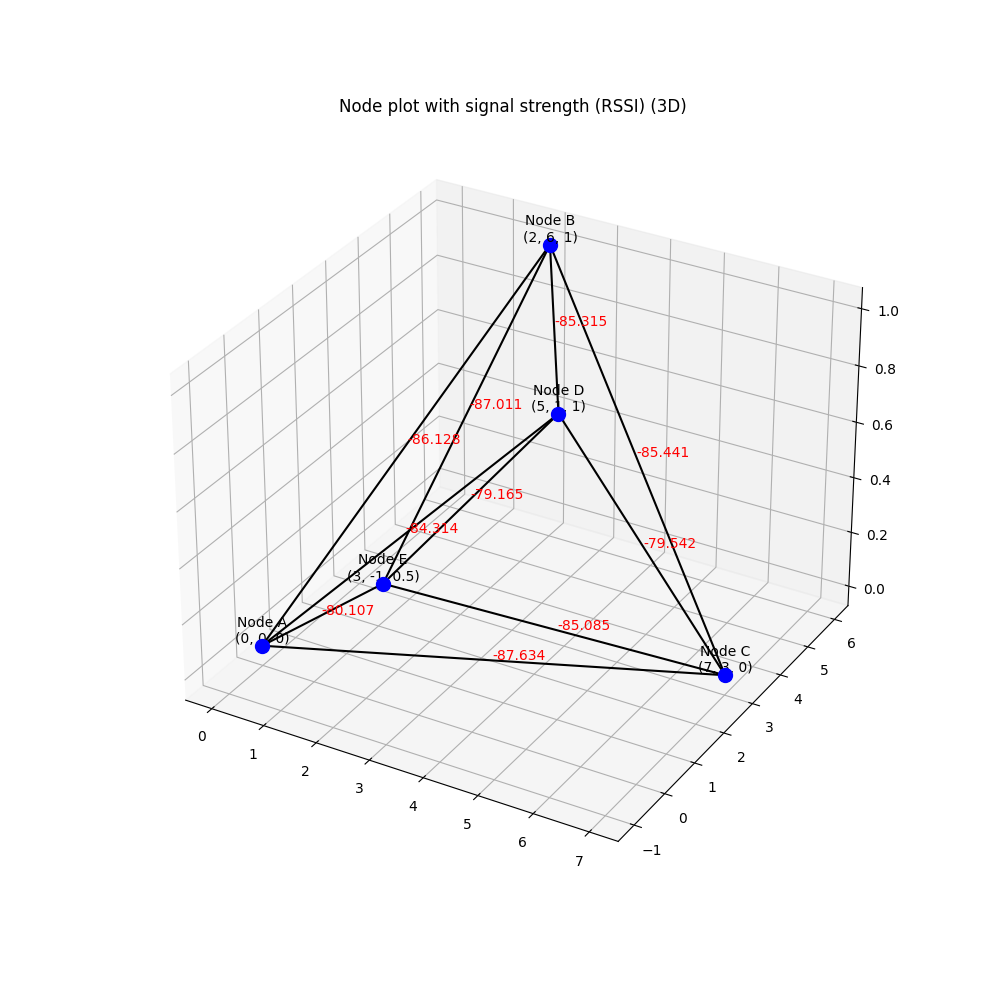

In [65]:
nodeList = []
RefNodeCoords = [(0,0,0),(2,6,1),(7,3,0),(5,1,1),(3,-1,0.5)]

names = list(map(chr,range(ord('A'),ord('Z')+1)))

for i in range(num_nodes): 
    nodeList.append(Node(names[i]))

printNodes(nodeList)

NetworkEdges = {}
for i in range(len(nodeList)):
    table = []
    for j in range(len(nodeList)):
        if nodeList[i] != nodeList[j]:
            table.append(Edge(nodeList[i], nodeList[j], distance_to_rssi(RefNodeCoords[i],RefNodeCoords[j])))
    table = sorted(table, key=lambda x: x.rssi, reverse=True)
    NetworkEdges[nodeList[i].uuid] = table

print('Reference Network Edges:')
for key, edges in NetworkEdges.items():
    print(f'Node {key}:= Edges{edges}')

compareGraph3D(NetworkEdges,RefNodeCoords)

<h1> Main: threading </h1>

In [66]:
# activate nodes, print function in parallel with Threading
maxTriangles = 3
thread_list = []
for i in range(len(nodeList)):
    thread = threading.Thread(target=nodeList[i].main, args=(NetworkEdges,maxTriangles))
    thread_list.append(thread)
    thread.start()

for thread in thread_list:
    thread.join()

------------------------------------------------------------------------------------------------
Node uuid=B:(0, 0, 0) [:] Surrounding Nodes= D, C, A, E, Edgelist= (B,D,5.831), (B,C,5.916), (B,A,6.403), (B,E,7.089)

TriangleList:
Triangle B|D|E: Area= 8.132, Edges= (B,D,5.831), (B,E,7.089), (D,E,2.872), Angles=(B,23.170), Altitude=(x=(B,1.393), H=(B,5.662))
Triangle B|C|D: Area= 8.515, Edges= (B,D,5.831), (B,C,5.916), (D,C,3.000), Angles=(B,29.581), Altitude=(x=(B,1.333), H=(B,5.676))
Triangle A|B|D: Area= 14.300, Edges= (B,D,5.831), (B,A,6.403), (D,A,5.196), Angles=(B,49.999), Altitude=(x=(B,1.925), H=(B,5.504))

Opposite edges=(D,E,2.872), (D,C,3.000), (D,A,5.196) [:]

Adjacent triangles of B:
Edge ('B', 'D'):
Triangle(B|D|E): x-coord=(D,5.831), map angle= 0.000 | xpos altitude=(E,0.686) | altitude height=(E,2.789) 
Triangle(B|C|D): x-coord=(X,0.000), map angle= 50.810 | xpos altitude=(C,0.686) | altitude height=(C,2.921) 
Triangle(A|B|D): x-coord=(X,0.000), map angle= 26.840 | xpos 